# Machine Learning Model Implementations
This file includes machine learning model implementations and their results on the processed data set.
The models used in order is as follows:
1. Grid Search
2. Gradient Descent
3. KNN (with DTW and MSE)
4. Naive Bayes
5. Decision Tree

### Import Packages and Load Dataset

Labels come from 2 different PSG systems: Remlogic and Somnomedics. EMFIT is the piezoelectric mat and Somnofy is the radar. Sleep stage labels are as follows:

0 = Awake \
1 = REM \
2 = Light \
3 = Deep

In [27]:
# Please run if dtaidistance package is not included
# !pip3 install dtaidistance

In [2]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from dtaidistance import dtw
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import numpy as np
from loader import *
from helpers import *

In [3]:
x, y, _, _ = get_nn_patients()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle = False, stratify = None)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((35, 857, 2), (15, 857, 2), (35, 857), (15, 857))

RADAR
              precision    recall  f1-score   support

         0.0       0.58      0.64      0.61      8649
         1.0       0.70      0.55      0.61      8503
         2.0       0.67      0.69      0.68     19483
         3.0       0.57      0.61      0.59      6215

    accuracy                           0.64     42850
   macro avg       0.63      0.62      0.62     42850
weighted avg       0.64      0.64      0.64     42850

Balanced accuracy: 0.6209542522230019
Accuracy: 0.6400233372228705
Accuracy per class: [0.63787721 0.54815947 0.69198789 0.60579244]


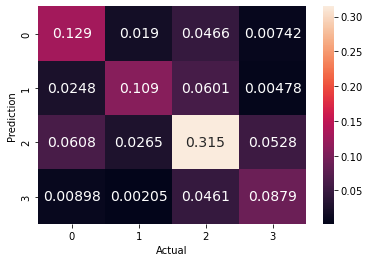


MAT
              precision    recall  f1-score   support

         0.0       0.23      0.64      0.34      3398
         1.0       0.42      0.28      0.34     10036
         2.0       0.61      0.55      0.58     22148
         3.0       0.41      0.37      0.38      7268

    accuracy                           0.47     42850
   macro avg       0.42      0.46      0.41     42850
weighted avg       0.50      0.47      0.47     42850

Balanced accuracy: 0.4603997106089155
Accuracy: 0.4652042007001167
Accuracy per class: [0.64067098 0.28049024 0.55458732 0.3658503 ]


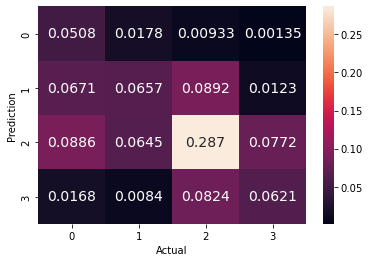

In [4]:
x_all, y_all = x.reshape(x.shape[0] * x.shape[1], 2), y.ravel()
radar, mat = x_all[:, 0], x_all[:, 1]
print("RADAR")
print(classification_report(radar,y_all))
print("Balanced accuracy:", balanced_accuracy_score(radar,y_all))
print("Accuracy:",accuracy_score(radar,y_all))
plot_conf_matrix(y_all, radar, normalize = True)

print("\nMAT")
print(classification_report(mat,y_all))
print("Balanced accuracy:", balanced_accuracy_score(mat,y_all))
print("Accuracy:",accuracy_score(mat,y_all))
plot_conf_matrix(y_all, mat, normalize = True)

In [5]:
train_size, test_size = x_train.shape[0] * x_train.shape[1], x_test.shape[0] * x_test.shape[1]
x_tr, x_te, y_tr, y_te = x_train.reshape(train_size,2), x_test.reshape(test_size,2), y_train.ravel(), y_test.ravel()

### Grid Search

In [6]:
x_tr_radar, x_tr_emfit = x_train[:,:,0].T, x_train[:,:,1].T
x_te_radar, x_te_emfit = x_test[:,:,0].T, x_test[:,:,1].T
y_tr_gd, y_te_gd = y_train.T, y_test.T
truth = y_te_gd.ravel()
x_tr_radar.shape, x_tr_emfit.shape, x_te_radar.shape, x_te_emfit.shape, y_tr_gd.shape, y_te_gd.shape

((857, 35), (857, 35), (857, 15), (857, 15), (857, 35), (857, 15))

In [7]:
def grid_search(radar, mat, psg, step=0.002, grid_limit=0.6):
    loss=100
    w_opt=np.zeros((2,1), dtype=float)
    w = np.zeros((2,1), dtype=float)
    while w[0] <= grid_limit:
        w[1]=0
        while w[1] <= grid_limit:
            e=np.zeros((radar.shape[0],radar.shape[1]))
            for i in range(radar.shape[1]):
                e[:,i]=(psg[:,i].reshape(radar.shape[0],1)-np.c_[mat[:,i],radar[:,i]].reshape(radar.shape[0],2)@w).reshape(radar.shape[0],)
            mse=np.zeros((radar.shape[1],1))
            for i in range(radar.shape[1]):
                mse[i]=1/2/radar.shape[0]*e[:,i].T@e[:,i]
            average_mse=np.mean(mse)
            if average_mse<loss:
                loss=average_mse
                w_opt[0], w_opt[1] = w[0], w[1]
            w[1]+=step
        w[0]+=step
    return w_opt

In [8]:
w = grid_search(x_tr_radar, x_tr_emfit, y_tr_gd, step=0.002, grid_limit=.8)
preds = get_predictions(w, x_te_emfit, x_te_radar).ravel() 

              precision    recall  f1-score   support

         0.0       0.85      0.39      0.53      3639
         1.0       0.28      0.77      0.41      1606
         2.0       0.68      0.69      0.68      5977
         3.0       0.69      0.29      0.41      1633

    accuracy                           0.56     12855
   macro avg       0.62      0.53      0.51     12855
weighted avg       0.68      0.56      0.57     12855

Balanced accuracy: 0.5340733326899778
Accuracy: 0.5642162582652664
Accuracy per class: [0.39021709 0.76650062 0.69114941 0.28842621]


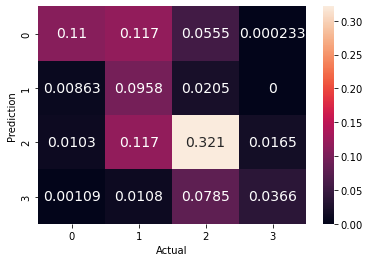

In [9]:
print(classification_report(truth,preds))
print("Balanced accuracy:", balanced_accuracy_score(truth,preds))
print("Accuracy:",accuracy_score(truth,preds))
plot_conf_matrix(preds, truth, normalize = True)

### Gradient Descent

In [10]:
size = x_tr_radar.shape[0]
psg = np.zeros((size,1))
for i in range(size):
    psg[i]=round(np.mean(y_tr_gd[i,:]))
emfit_mean=np.zeros((size,1))
for i in range(size):
    emfit_mean[i]=np.mean(x_tr_emfit[i,:])
somnofy_mean=np.zeros((size,1))
for i in range(size):
    somnofy_mean[i]=np.mean(x_tr_radar[i,:])

w, loss_m1= mse_gd(emfit_mean, somnofy_mean, psg, max_iters=1500, gamma=0.005,w0=True)

In [11]:
preds = get_predictions(w, x_te_emfit, x_te_radar).ravel()

              precision    recall  f1-score   support

         0.0       0.85      0.39      0.53      3639
         1.0       0.28      0.79      0.41      1606
         2.0       0.64      0.71      0.67      5977
         3.0       0.00      0.00      0.00      1633

    accuracy                           0.54     12855
   macro avg       0.44      0.47      0.41     12855
weighted avg       0.57      0.54      0.52     12855

Balanced accuracy: 0.47254127709047467
Accuracy: 0.5402567094515752
Accuracy per class: [0.39021709 0.78704857 0.71289945 0.        ]


/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


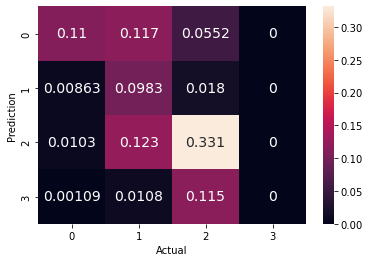

In [12]:
print(classification_report(truth,preds))
print("Balanced accuracy:", balanced_accuracy_score(truth,preds))
print("Accuracy:",accuracy_score(truth,preds))
plot_conf_matrix(preds, truth, normalize = True)

### KNN Classifier

#### KNN with Dynamic Time Wraping from tslearn
This classifier takes very long time, we advice you not to re-run.

In [24]:
knn_classifier = KNeighborsClassifier(n_neighbors=10, metric=dtw.distance, n_jobs=-1)
knn_classifier.fit(x_tr, y_tr)

KNeighborsClassifier(metric=<function distance at 0x7fe2e08e8820>, n_jobs=-1,
                     n_neighbors=10)

In [25]:
preds = knn_classifier.predict(x_te)

              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70      3639
         1.0       0.59      0.37      0.45      1606
         2.0       0.64      0.74      0.68      5977
         3.0       0.61      0.55      0.58      1633

    accuracy                           0.65     12855
   macro avg       0.64      0.58      0.60     12855
weighted avg       0.65      0.65      0.65     12855

Balanced accuracy: 0.5844355266033772
Accuracy: 0.6513418903150525
Accuracy per class: [0.6784831  0.36924035 0.73766103 0.55235762]


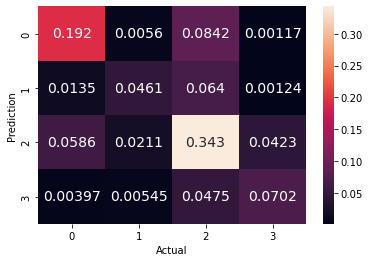

In [26]:
print(classification_report(y_te,preds))
print("Balanced accuracy:", balanced_accuracy_score(y_te,preds))
print("Accuracy:",accuracy_score(y_te,preds))
plot_conf_matrix(preds, y_te, normalize = True)

#### KNN with MSE

In [13]:
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(x_tr, y_tr)
preds = knn_classifier.predict(x_te)

              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70      3639
         1.0       0.59      0.37      0.45      1606
         2.0       0.64      0.74      0.68      5977
         3.0       0.61      0.55      0.58      1633

    accuracy                           0.65     12855
   macro avg       0.64      0.58      0.60     12855
weighted avg       0.65      0.65      0.65     12855

Balanced accuracy: 0.5844355266033772
Accuracy: 0.6513418903150525
Accuracy per class: [0.6784831  0.36924035 0.73766103 0.55235762]


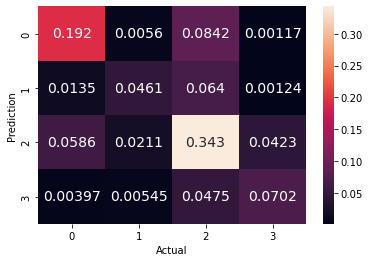

In [14]:
print(classification_report(y_te,preds))
print("Balanced accuracy:", balanced_accuracy_score(y_te,preds))
print("Accuracy:",accuracy_score(y_te,preds))
plot_conf_matrix(preds, y_te, normalize = True)

### Naive Bayes 

In [15]:
cnb_classifier = CategoricalNB()
cnb_classifier.fit(x_tr, y_tr)

CategoricalNB()

In [16]:
preds = cnb_classifier.predict(x_te)

              precision    recall  f1-score   support

         0.0       0.72      0.63      0.68      3639
         1.0       0.63      0.68      0.65      1606
         2.0       0.68      0.73      0.70      5977
         3.0       0.61      0.55      0.58      1633

    accuracy                           0.67     12855
   macro avg       0.66      0.65      0.65     12855
weighted avg       0.68      0.67      0.67     12855

Balanced accuracy: 0.6491210336707802
Accuracy: 0.6749902761571372
Accuracy per class: [0.63369057 0.67745953 0.73297641 0.55235762]


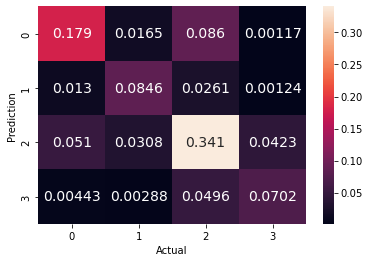

In [17]:
print(classification_report(y_te,preds))
print("Balanced accuracy:", balanced_accuracy_score(y_te,preds))
print("Accuracy:",accuracy_score(y_te,preds))
plot_conf_matrix(preds, y_te, normalize = True)

### Decision Tree

In [18]:
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(x_tr, y_tr) 
preds = classifier_feature.predict(x_te)

              precision    recall  f1-score   support

         0.0       0.73      0.63      0.68      3639
         1.0       0.62      0.68      0.65      1606
         2.0       0.68      0.73      0.70      5977
         3.0       0.61      0.55      0.58      1633

    accuracy                           0.67     12855
   macro avg       0.66      0.65      0.65     12855
weighted avg       0.68      0.67      0.67     12855

Balanced accuracy: 0.6485506278240203
Accuracy: 0.674679113185531
Accuracy per class: [0.62956856 0.67745953 0.7348168  0.55235762]


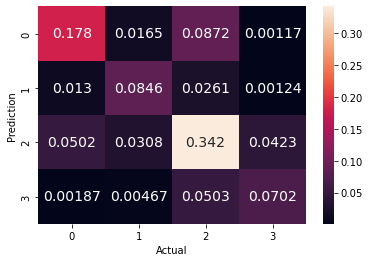

In [19]:
print(classification_report(y_te,preds))
print("Balanced accuracy:", balanced_accuracy_score(y_te,preds))
print("Accuracy:",accuracy_score(y_te,preds))
plot_conf_matrix(preds, y_te, normalize = True)